# Ansatze and Variational Forms

At the heart of all variational algorithms lies the key idea of analyzing the differences between states, which are conveniently related through some well-behaved mapping (e.g., continuous, differentiable) from a set of parameters or variables — hence the name.

First, we'll explore how to construct parameterized circuits by hand. We'll use these circuits to define a variational form that represents a collection of parameterized states for our variational algorithm to explore. Then, we'll construct our ansatz by applying this variational form to our reference state.

We'll also explore how to trade off speed versus accuracy while exploring this search space.

![alt text](../../../img/ansatz_workflow.svg)

# Table of Contents

1. [Parameterized Quantum Circuits](#parameterized-quantum-circuits)  
2. [Variational Form and Ansatz](#variational-form-and-ansatz)  
   - [Heuristic Ansatze and Trade-offs](#heuristic-ansatze-and-trade-offs)  
   - [N-local Circuits](#n-local-circuits)  
   - [EfficientSU2](#efficientsu2)  
   - [Problem-specific Ansatze](#problem-specific-ansatze)  
3. [Optimization](#optimization)  
4. [Quantum Machine Learning](#quantum-machine-learning)  
5. [Summary](#summary)


## Parameterized Quantum Circuits

Variational algorithms operate by exploring and comparing a range of quantum states $|\psi(\vec{\theta})\rangle$, which depend on a finite set of $k$ parameters $\vec{\theta} = (\theta^0, \ldots, \theta^{k-1})$. These states can be prepared using a parametrized quantum circuit, where gates are defined with tunable parameters. It is possible to create this parametrized circuit without binding specific angles yet:


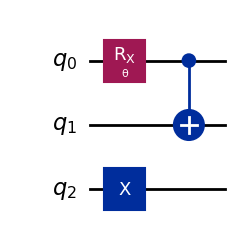

In [1]:
from qiskit.circuit import QuantumCircuit, Parameter

theta = Parameter("θ")

qc = QuantumCircuit(3)
qc.rx(theta, 0)
qc.cx(0, 1)
qc.x(2)

qc.draw("mpl")

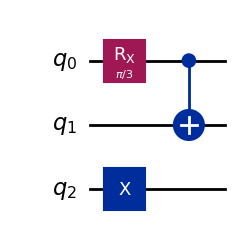

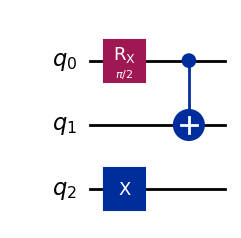

In [2]:
from math import pi

angle_list = [pi / 3, pi / 2]
circuits = [qc.assign_parameters({theta: angle}) for angle in angle_list]

for circuit in circuits:
    display(circuit.draw("mpl"))

## Variational Form and Ansatz

To iteratively optimize from a reference state $|\rho\rangle$ to a target state $|\psi(\vec{\theta})\rangle$, we need to define a variational form $U_V(\vec{\theta})$ that represents a collection of parametrized states for our variational algorithm to explore:

$$
\begin{aligned}
|0\rangle 
& \xrightarrow{U_R} U_R |0\rangle = |\rho\rangle 
\xrightarrow{U_V(\vec{\theta})} U_A(\vec{\theta}) |0\rangle \\
&= U_V(\vec{\theta}) U_R |0\rangle \\
&= U_V(\vec{\theta}) |\rho\rangle \\
&= |\psi(\vec{\theta})\rangle
\end{aligned}
$$

Note that the parametrized state depends on both the reference state $|\rho\rangle$, which does not depend on any parameters, and the variational form $U_V(\vec{\theta})$, which always depends on parameters. We refer to the combination of these two halves as an ansatz:  
$U_A(\vec{\theta}) := U_V(\vec{\theta}) U_R$.

As we construct our ansatz to represent a collection of parametrized states for our variational algorithm to explore, we realize an important issue: dimensionality. An $n$-qubit system (i.e., Hilbert space) has a vast number of distinct quantum states in the configuration space. We would require an unwieldy number of parameters to fully explore it. Quantitatively, its dimensionality is $D = 2^{2n}$. To make matters worse, the runtime complexity of search algorithms, and others alike, grows exponentially with this dimensionality, a phenomenon often referred to in the literature as the curse of dimensionality.

To counter this setback, it is common practice to impose some reasonable constraints on the variational form such that only the most relevant states are explored. Finding an efficient truncated ansatz is an active area of research, but we’ll cover two common designs.

### Heuristic Ansatze and Trade-offs

If you do not have any information about your particular problem that can help restrict the dimensionality, you can try an arbitrary family of parameterized circuits with fewer than $2^{2n}$ parameters. However, there are some trade-offs to consider:

- **Speed**: By reducing the search space, the algorithm can run faster.
- **Accuracy**: However, reducing the space could risk excluding the actual solution to the problem, leading to suboptimal solutions.
- **Noise**: Deeper circuits are affected by noise, so we need to experiment with our ansatz’s connectivity, gates, and gate fidelity.

There is a fundamental trade-off between quality (or even solvability) and speed: the more parameters, the more likely you are to find a precise result, but the longer it will take to run the algorithm.

### N-local Circuits


One of the most widely used examples of heuristic ansatzes is the **N-local circuits**, for a few reasons:

- **Efficient implementation**: The N-local ansatz is typically composed of simple, local gates that can be implemented efficiently on a quantum computer, using a small number of physical qubits. This makes it easier to construct and simulate quantum circuits.
- **Captures important correlations**: The N-local ansatz can capture important correlations between the qubits in a quantum system with a small number of gates. This is because local gates can act on neighboring qubits and create entanglement between them, which is a small but meaningful step toward simulating complex quantum systems.

These circuits consist of rotation and entanglement layers that are repeated alternatively one or more times as follows:

- Each layer is formed by gates of size at most $N$, where $N$ has to be lower than the number of qubits.
- For a rotation layer, the gates are stacked on top of each other. We can use standard rotation operations, such as `RX` or `CRZ`.
- For an entanglement layer, we can use gates like `Toffoli` gates or `CX` with an entanglement strategy.
- Both types of layers can be parameterized or not, but at least one of them needs to contain parameters. Otherwise, without at least one parameter, there wouldn’t be any variations!
- Optionally, an extra rotation layer is added to the end of the circuit.

For example, let’s create a 5-qubit `NLocal` circuit with rotation blocks formed by `RX` and `CRZ` gates, entanglement blocks formed by `Toffoli` gates that act on qubits $[0, 1, 2]$, $[0, 2, 3]$, $[4, 2, 1]$ and $[3, 1, 0]$ and 2 repetitions of each layer.




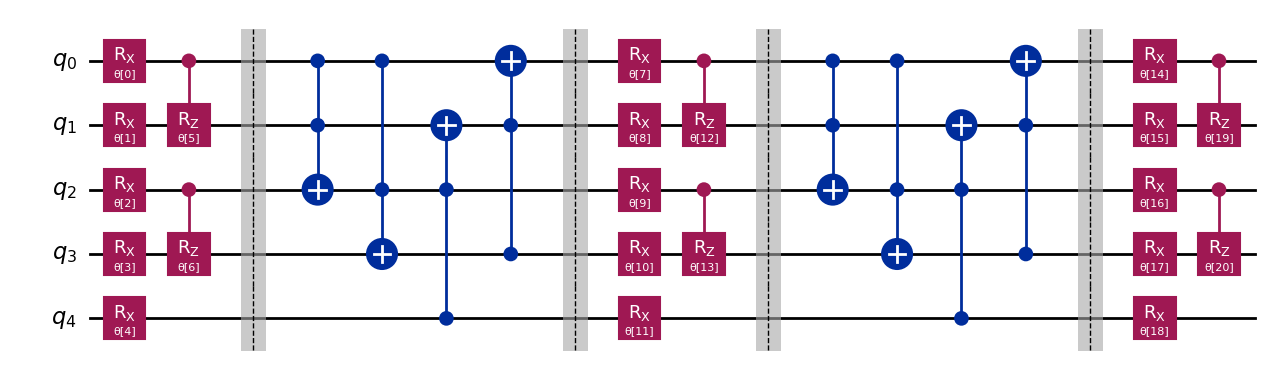

In [3]:
from qiskit.circuit.library import NLocal, CCXGate, CRZGate, RXGate
from qiskit.circuit import Parameter

theta = Parameter("θ")
ansatz = NLocal(
    num_qubits=5,
    rotation_blocks=[RXGate(theta), CRZGate(theta)],
    entanglement_blocks=CCXGate(),
    entanglement=[[0, 1, 2], [0, 2, 3], [4, 2, 1], [3, 1, 0]],
    reps=2,
    insert_barriers=True,
)
ansatz.decompose().draw("mpl")

In the above example, the largest gate is the Toffoli gate, which acts on three qubits, making the circuit 3-local. The most commonly used type of N-local circuits are 2-local circuits with single-qubit rotation gates and 2-qubit entanglement gates.

Let's create a 2-local circuit using Qiskit's TwoLocal class. The syntax is the same as NLocal , but there are some differences. For instance, most gates, such as RX , RZ , and CNOT , can be passed as strings without importing the gates or creating a Parameter instance.

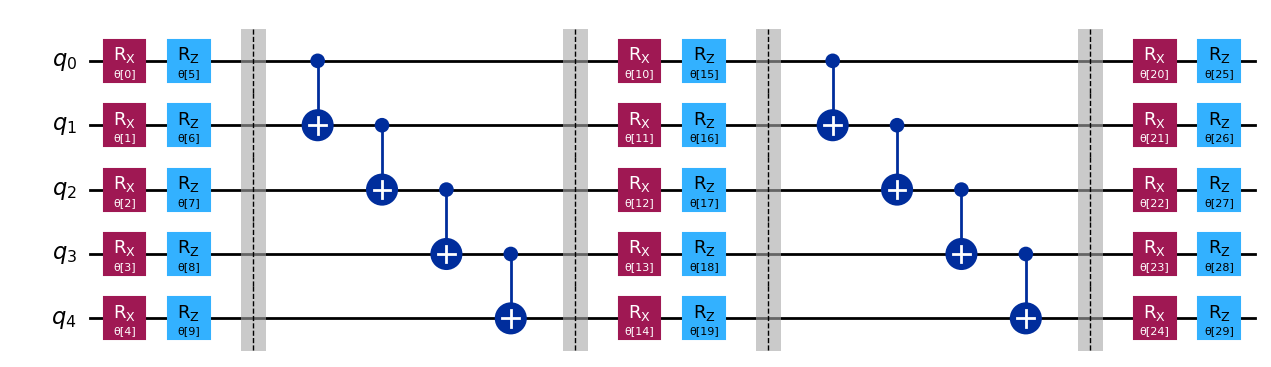

In [4]:
from qiskit.circuit.library import TwoLocal

ansatz = TwoLocal(
    num_qubits=5,
    rotation_blocks=["rx", "rz"],
    entanglement_blocks="cx",
    entanglement="linear",
    reps=2,
    insert_barriers=True,
)
ansatz.decompose().draw("mpl")

In this case, we used the linear entanglement distribution, where each qubit is entangled with the next. To learn about other strategies, refer to `TwoLocal` [documentation](https://docs.quantum.ibm.com/api/qiskit/qiskit.circuit.library.TwoLocal).

### EfficientSU2

`EfficientSU2`is a hardware-efficient circuit that consists of layers of single-qubit operations spanning SU(2) and `CX` entanglements. This is a heuristic pattern that can be used to prepare trial wave functions for variational quantum algorithms or as a classification circuit for machine learning.


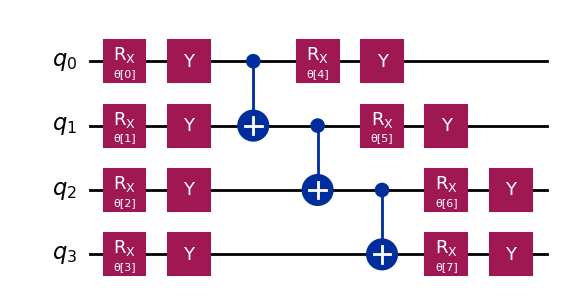

In [5]:
from qiskit.circuit.library import EfficientSU2

ansatz = EfficientSU2(4, su2_gates=["rx", "y"], entanglement="linear", reps=1)
ansatz.decompose().draw("mpl")

### Problem-specific Ansatze

While heuristic and hardware efficient ansatze help us to solve a problem in a naive way, we can use problem-specific knowledge to restrict our circuit search space to a specific type. This will help us to gain speed without losing accuracy in our search process.


## Optimization

In a max-cut problem, we want to partition nodes of a graph in a way that maximizes the number of edges between nodes in differing groups. The desired max-cut partition for the graph below is clear: the 0th-node on the left should be separated from the rest of the nodes on the right by a cut.


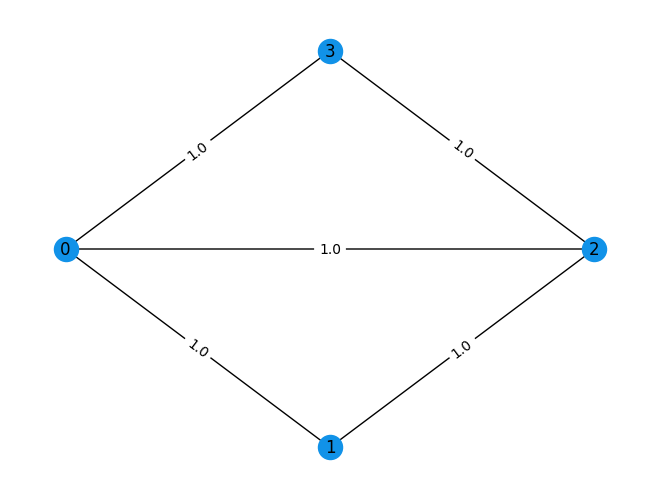

In [6]:
import rustworkx as rx
from rustworkx.visualization import mpl_draw

n = 4
G = rx.PyGraph()
G.add_nodes_from(range(n))
# The edge syntax is (start, end, weight)
edges = [(0, 1, 1.0), (0, 2, 1.0), (0, 3, 1.0), (1, 2, 1.0), (2, 3, 1.0)]
G.add_edges_from(edges)

mpl_draw(G, pos=rx.shell_layout(G), with_labels=True, edge_labels=str, node_color="#1192E8")

To utilize QAOA algorithm for a max-cut problem, we require a Pauli Hamiltonian that encodes the cost in a manner such that the minimum expectation value of the operator corresponds to the maximum number of edges between the nodes in two different groups.

For this simple example, the operator is a linear combination of terms with Z operators on nodes connected by an edge (recall that the 0th qubit is farthest right): $ ZZII + IZZI + ZIZZ + IIZZ $ Once the operator is constructed, the ansatz for the QAOA algorithm can easily be built by using the `QAOAAnsatz` circuit from the Qiskit circuit library.

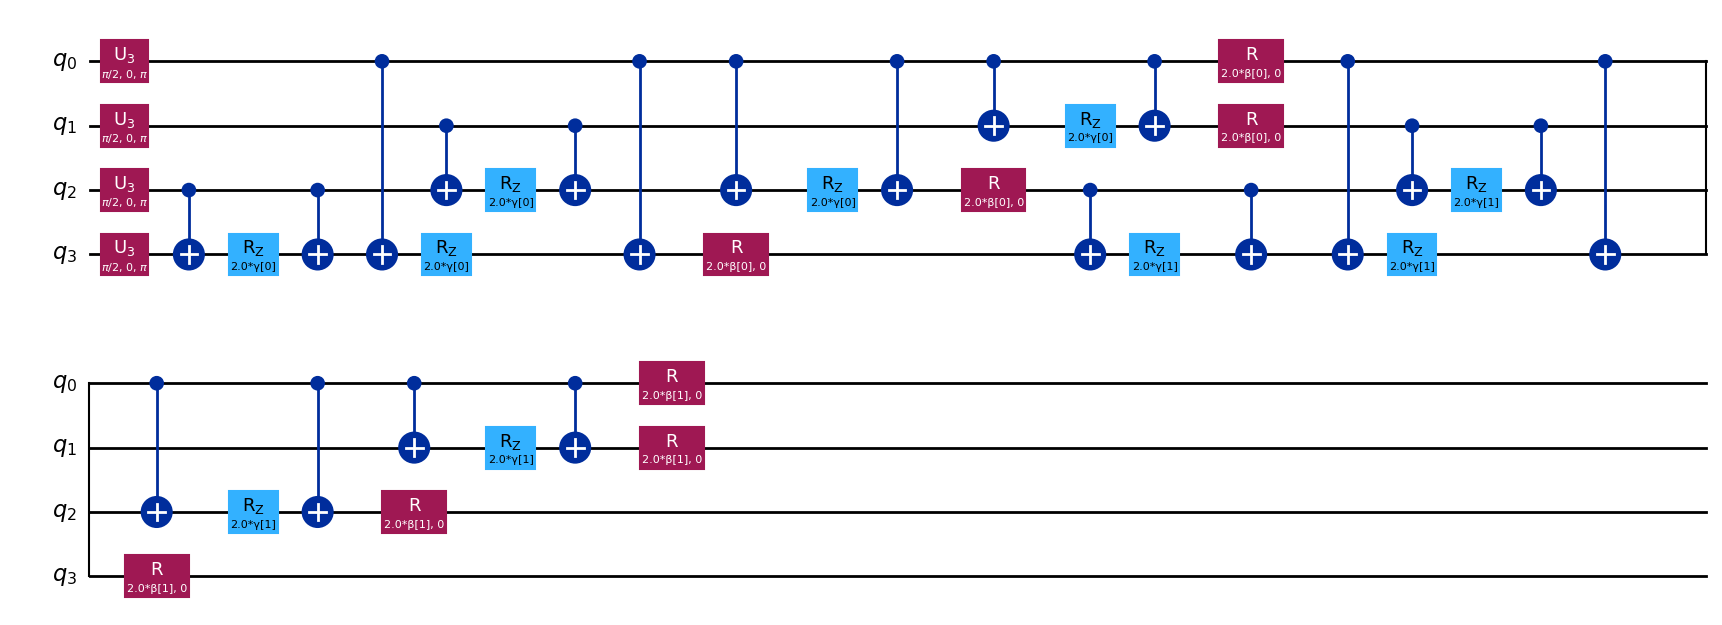

In [7]:
# Pre-defined ansatz circuit, operator class and visualization tools
from qiskit.circuit.library import QAOAAnsatz
from qiskit.quantum_info import SparsePauliOp

# Problem to Hamiltonian operator
hamiltonian = SparsePauliOp.from_list([("ZZII", 1), ("IZZI", 1), ("ZIIZ", 1), ("IZIZ", 1), ("IIZZ", 1)])
# QAOA ansatz circuit
ansatz = QAOAAnsatz(hamiltonian, reps=2)
# Draw
ansatz.decompose(reps=3).draw("mpl")

The previous image illustrates the ansatz in basic gates for clarity. However, it can be expressed in multiple levels of decomposition by changing the reps argument or by drawing the circuit without the decompose method. For example, the following representation directly shows the QAOA structure with the default reps value, which is reps=1 .

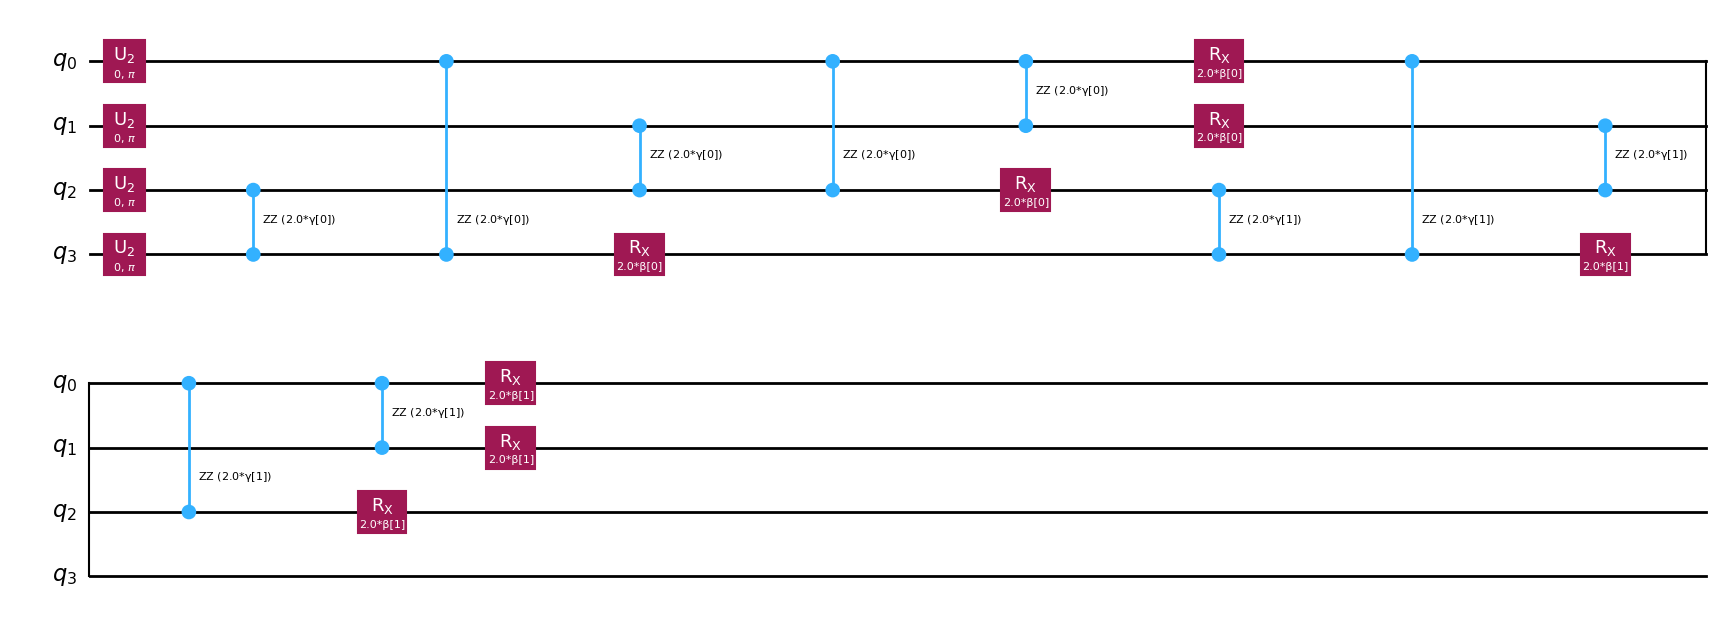

In [8]:
ansatz.decompose(reps=2).draw("mpl")

## Quantum Machine Learning

In machine learning, a common application is the classification of data into two or more categories. This involves encoding a datapoint into a feature map that maps classical feature vectors into the quantum Hilbert space. Constructing quantum feature maps based on parameterized quantum circuits that are hard to simulate classically is an important step towards obtaining a potential advantage over classical machine learning approaches and is an active area of current research.

The ZZFeatureMap can be used to create a parameterized circuit. We can pass in our data points to the feature map (x) and a separate variational form to pass in weights as parameter $\theta $


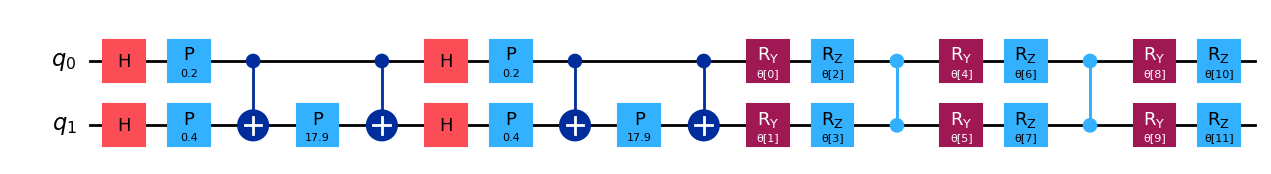

In [9]:
from qiskit.circuit.library import ZZFeatureMap, TwoLocal

data = [0.1, 0.2]

zz_feature_map_reference = ZZFeatureMap(feature_dimension=2, reps=2)
zz_feature_map_reference = zz_feature_map_reference.assign_parameters(data)

variation_form = TwoLocal(2, ["ry", "rz"], "cz", reps=2)
vqc_ansatz = zz_feature_map_reference.compose(variation_form)
vqc_ansatz.decompose().draw("mpl")

## Summary

With this lesson, you learned how to define your search space with a variational form:

- Prepare states with a parametrized quantum circuit, where gates are defined with tunable parameters.
- How to construct ansatze that tradeoff speed vs accuracy
- Heuristic ansatze
- Problem-specific ansatze

Our high-level variational workload looks as follows:

![alt text](../../../img/ansatz_workflow.svg)

For each variational parameter $\vec{\theta}$, a different quantum state will be produced. To find the optimal parameters, we need to define a problem-specific *cost function* to iteratively update our ansatz’s parameters.
